In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from dataset.dataloader import CINE2DT
from model.model_pytorch import CRNN_MRI
# from utils import multicoil2single, compressed_sensing as cs,IFFT2c
from utils import multicoil2single, compressed_sensing as cs
from utils.fastmriBaseUtils import IFFT2c
from utils.dnn_io import to_tensor_format, from_tensor_format
from utils import mymath
# from trainer_dcrnn_test_demo import prep_input
# from trainer_dcrnn_test_demo import prep_input
from torch.autograd import Variable
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '5'  # 指定使用 GPU 1 和 GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Loaded variables: dict_keys(['__header__', '__version__', '__globals__', 'mask'])
Mask shape: (192, 18)


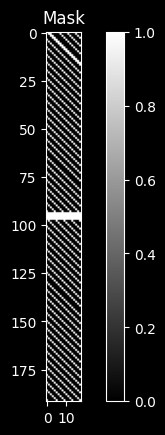

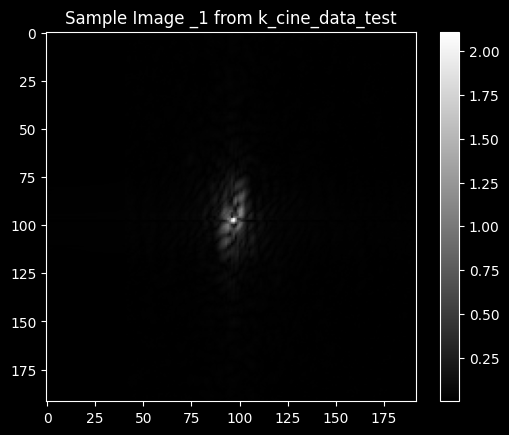

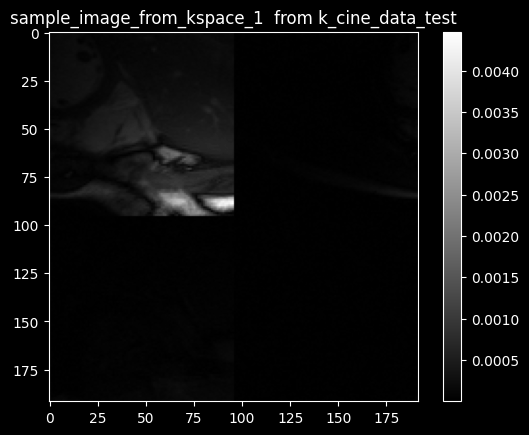

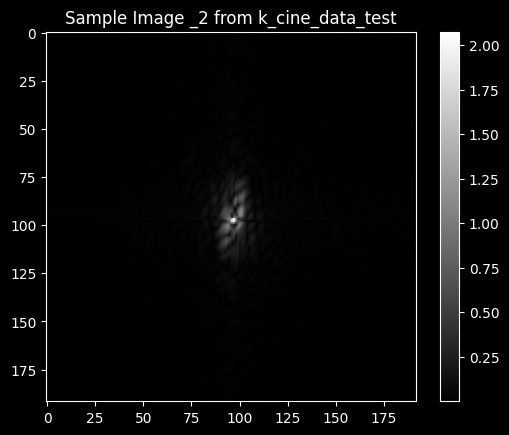

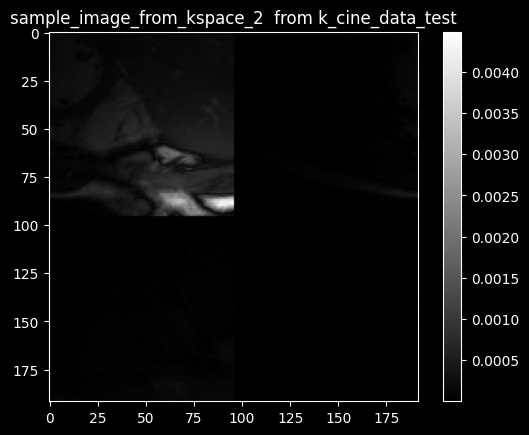

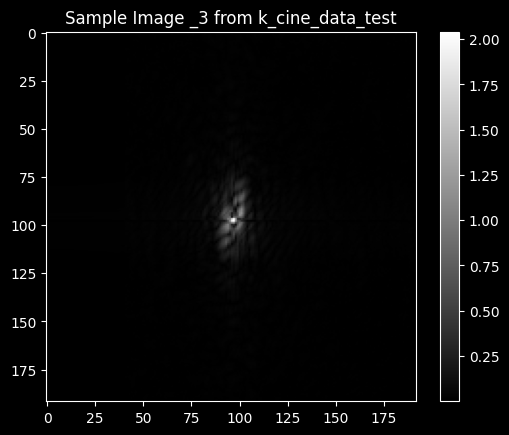

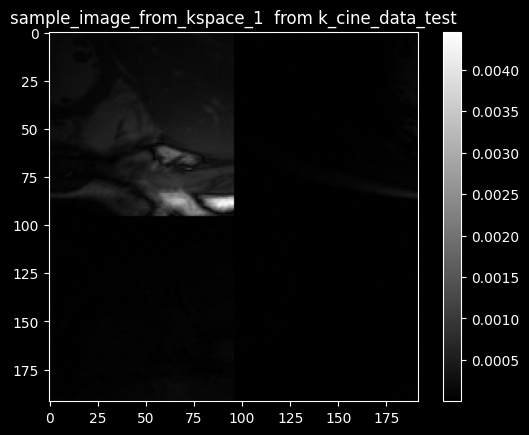

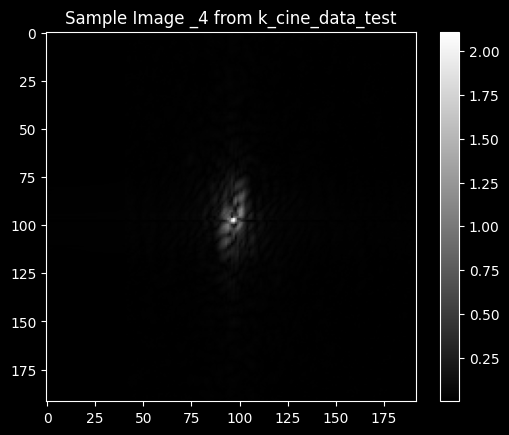

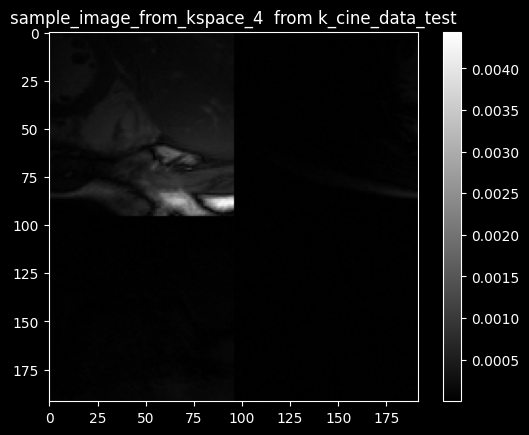

In [7]:
import scipy.io
import matplotlib.pyplot as plt

import numpy as np
# k_cine_data = np.load('/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy')
# # (800, 20, 18, 192, 192)
# print(k_cine_data.shape)

k_cine_data_test = np.load('/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy')
# (118, 20, 18, 192, 192)
# print(k_cine_data_test.shape)


#
# 读取 .mat 文件
file_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/masks/VISTA/e_192x18_acs4_R4.mat'
data = scipy.io.loadmat(file_path)


# 打印 .mat 文件中的所有变量
print("Loaded variables:", data.keys())

# 假设掩码存储在名为 'mask' 的变量中
mask = data['mask']  # 如果变量名不同，请根据实际情况修改

# 打印掩码的维度 Mask shape: (192, 18)
print("Mask shape:", mask.shape)

# 显示掩码
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.colorbar()
plt.show()

# 显示最后两个维度的数据
# 选择第一个样本，第一个线圈，第一个时间点
sample_image_1 = k_cine_data_test[0, 1, 0, :, :]
plt.imshow(np.abs(sample_image_1), cmap='gray')
plt.title('Sample Image _1 from k_cine_data_test')
plt.colorbar()
plt.show()

sample_image_from_kspace_1 = np.fft.ifft2(sample_image_1)  # 逆傅里叶变换
plt.imshow(np.abs(sample_image_from_kspace_1), cmap='gray')
plt.title('sample_image_from_kspace_1  from k_cine_data_test')
plt.colorbar()
plt.show()

# 选择第一个样本，第一个线圈，第一个时间点
sample_image_2 = k_cine_data_test[0, 1, 1, :, :]
plt.imshow(np.abs(sample_image_2), cmap='gray')
plt.title('Sample Image _2 from k_cine_data_test')
plt.colorbar()
plt.show()

sample_image_from_kspace_2 = np.fft.ifft2(sample_image_2)  # 逆傅里叶变换
plt.imshow(np.abs(sample_image_from_kspace_2), cmap='gray')
plt.title('sample_image_from_kspace_2  from k_cine_data_test')
plt.colorbar()
plt.show()

# 选择第一个样本，第一个线圈，第一个时间点
sample_image_3 = k_cine_data_test[0, 1, 2, :, :]
plt.imshow(np.abs(sample_image_3), cmap='gray')
plt.title('Sample Image _3 from k_cine_data_test')
plt.colorbar()
plt.show()

sample_image_from_kspace_3 = np.fft.ifft2(sample_image_3)  # 逆傅里叶变换
plt.imshow(np.abs(sample_image_from_kspace_3), cmap='gray')
plt.title('sample_image_from_kspace_1  from k_cine_data_test')
plt.colorbar()
plt.show()

# 选择第一个样本，第一个线圈，第一个时间点
sample_image_4 = k_cine_data_test[0, 1, 3, :, :]
plt.imshow(np.abs(sample_image_1), cmap='gray')
plt.title('Sample Image _4 from k_cine_data_test')
plt.colorbar()
plt.show()

sample_image_from_kspace_4 = np.fft.ifft2(sample_image_4)  # 逆傅里叶变换
plt.imshow(np.abs(sample_image_from_kspace_4), cmap='gray')
plt.title('sample_image_from_kspace_4  from k_cine_data_test')
plt.colorbar()
plt.show()

In [8]:
import scipy.io as scio
def get_cine_mask(acc, acs_lines, x=232, y=256):
   rows = y-acs_lines

   matrix = np.zeros((rows, x))

   ones_per_column = rows//acc #y//acc-acs_lines

   first_column = np.zeros(rows)
   indices = np.linspace(0, rows - 1, ones_per_column, dtype=int)
   first_column[indices] = 1

   for j in range(x):
       matrix[:, j] = np.roll(first_column, j)
       
   insert_rows = np.ones((acs_lines, x))
   new_matrix = np.insert(matrix, rows//2, insert_rows, axis=0)
   print(new_matrix)
#    mask = np.transpose(mask, (0, 2, 1))
#
   mask_datadict = {'mask': np.squeeze(new_matrix)}
##    scio.savemat('random_368x368_mask4x_8line.mat', mask_datadict)  #
   # scio.savemat('/data0/huayu/Aluochen/Mypaper5/e_192x18_acs4_R4.mat', mask_datadict)
   return new_matrix.astype(np.float64)  # 数据类型设为 float64 以匹配后续处理

[[1. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]]
(192, 18)


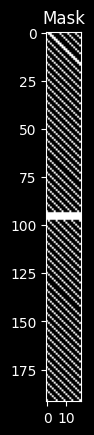

(18, 192)


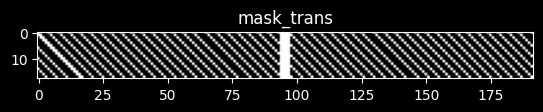

(2, 192, 192, 18)
(2, 192, 18, 192)


In [9]:
mask = get_cine_mask(acc=4, acs_lines=4, x=18, y=192)
# (192, 18)
print(mask.shape)

# 显示 mask
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

# class CINE2DT(torch.utils.data.Dataset): 里有以下代码：
# # 对 self.mask 进行转置操作。
# self.mask = np.transpose(self.mask,[1,0])
mask_trans = np.transpose(mask,[1,0])
# (18, 192)
print(mask_trans.shape)
# 显示 mask
plt.imshow(mask_trans, cmap='gray')
plt.title('mask_trans')
plt.show()

mask = np.expand_dims(mask, axis=0)  # 添加 batch 维度
mask = np.expand_dims(mask, axis=0)  # 添加 time 维度
# mask = np.tile(mask, (batch_size, time, 1, 1))  # 广播到完整形状
mask = np.tile(mask, (2, 192, 1, 1))  # 广播到完整形状
# (2, 192, 192, 18) 原始的：# (192, 18)
print(mask.shape)


mask_trans = np.expand_dims(mask_trans, axis=0)  # 添加 batch 维度
mask_trans = np.expand_dims(mask_trans, axis=0)  # 添加 time 维度
# mask = np.tile(mask, (batch_size, time, 1, 1))  # 广播到完整形状
mask_trans = np.tile(mask_trans, (2, 192, 1, 1))  # 广播到完整形状
# (2, 192, 18, 192)
print(mask_trans.shape)

[[1. 1. 0. ... 1. 0. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(192, 192)


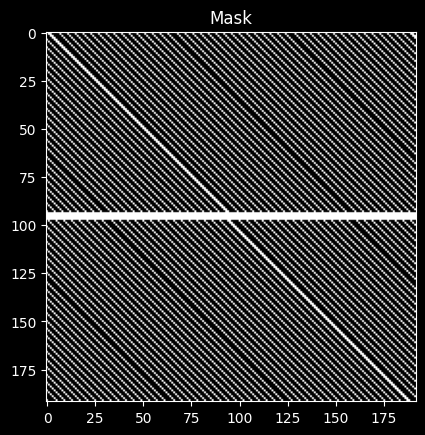

(2, 18, 192, 192)


In [7]:
mask = get_cine_mask(acc=4, acs_lines=4, x=192, y=192)
print(mask.shape)

# 显示 mask
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()
mask = np.expand_dims(mask, axis=0)  # 添加 batch 维度
mask = np.expand_dims(mask, axis=0)  # 添加 time 维度
# mask = np.tile(mask, (batch_size, time, 1, 1))  # 广播到完整形状
mask = np.tile(mask, (2, 18, 1, 1))  # 广播到完整形状
print(mask.shape)

[[1. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]]
(192, 18)


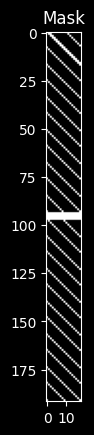

In [10]:
mask = get_cine_mask(acc=8, acs_lines=4, x=18, y=192)
print(mask.shape)

# 显示 mask
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

In [3]:
# import torch

# def r2c_5d_to_4d(x):
#     # 检查输入是否为numpy数组，如果是，则转换为Tensor
#     if isinstance(x, np.ndarray):
#         x = torch.from_numpy(x)
    
#     # 假设x的形状为[batch_size, 2, height, width, channels]
#     # 我们将第一个维度（大小为2）的实部和虚部分别取出
#     re = x[:, 0, :, :, :]  # 实部
#     im = x[:, 1, :, :, :]  # 虚部
    
#     # 创建复数张量
#     x_complex = torch.complex(re, im)
    
#     # 返回四维张量，形状为[batch_size, height, width, channels]
#     return x_complex

# # 假设输入张量的形状为[2, 2, 192, 192, 18]
# # 使用上面的函数将其转换为四维复数张量
# input_tensor = torch.randn(2, 2, 192, 192, 18)
# output_tensor = r2c_5d_to_4d(input_tensor)

# print(f"Output tensor shape: {output_tensor.shape}")
# print(f"Output tensor dtype: {output_tensor.dtype}")

# # 使用torch.view_as_real将复数张量转换为实数张量
# output_real_tensor = torch.view_as_real(output_tensor)

# # 输出张量的形状应该是[batch_size, height, width, channels * 2]
# # 因为复数张量的每个元素都由一个实部和虚部组成
# print(f"Output real tensor shape: {output_real_tensor.shape}")
# print(f"Output real tensor dtype: {output_real_tensor.dtype}")

# # 只保留复数张量的实部
# output_real_tensor = torch.real(output_tensor)
# # 或者只保留复数张量的虚部
# # output_real_tensor = torch.imag(output_tensor)
# # 输出张量的形状仍然是[batch_size, height, width, channels]
# print(f"Output real tensor shape: {output_real_tensor.shape}")
# print(f"Output real tensor dtype: {output_real_tensor.dtype}")






Output tensor shape: torch.Size([2, 192, 192, 18])
Output tensor dtype: torch.complex64
Output real tensor shape: torch.Size([2, 192, 192, 18, 2])
Output real tensor dtype: torch.float32
Output real tensor shape: torch.Size([2, 192, 192, 18])
Output real tensor dtype: torch.float32


In [3]:
from numpy.lib.stride_tricks import as_strided

def normal_pdf(length, sensitivity):
    return np.exp(-sensitivity * (np.arange(length) - length / 2)**2)

def cartesian_mask(shape, acc, sample_n=10, centred=False):
    """
    Sampling density estimated from implementation of kt FOCUSS
    shape: tuple - of form (..., nx, ny)
    acc: float - doesn't have to be integer 4, 8, etc..
这段代码实现了一个生成笛卡尔采样掩码（Cartesian Mask）的函数 cartesian_mask，
通常用于磁共振成像（MRI）中的欠采样（undersampling）任务。
掩码的作用是决定在 k 空间（频率域）中哪些数据点被采样，哪些被忽略。以下是对代码的详细解读：
函数功能
目标：生成一个笛卡尔采样掩码，用于模拟 MRI 中的欠采样过程。
输入参数：
shape：掩码的形状，格式为 (..., nx, ny)，其中 nx 和 ny 是 k 空间的尺寸。
acc：加速因子（acceleration factor），控制欠采样的程度。
sample_n：中心区域的采样点数，通常用于保留 k 空间中心的低频信息。
centred：是否将掩码中心化（默认不中心化）。
输出：返回一个与 shape 形状相同的掩码，值为 0 或 1，表示是否采样。
功能：
生成一个笛卡尔采样掩码，用于 MRI 中的欠采样任务。
支持控制加速因子、中心区域采样点数和是否中心化。
核心逻辑：
使用正态分布和均匀分布的混合 PDF 随机选择采样点。
强制保留 k 空间中心区域的采样点。
应用场景：
用于模拟 MRI 中的欠采样过程，生成训练数据或测试数据。
    """
    # N：除了最后两个维度（nx 和 ny）之外的所有维度的乘积。 Nx 和 Ny：k 空间的尺寸（nx 和 ny）。
    N, Nx, Ny = int(np.prod(shape[:-2])), shape[-2], shape[-1]
    # 生成概率密度函数（PDF）
#     normal_pdf：
# 生成一个正态分布的概率密度函数（PDF），用于控制采样点的分布。
# 正态分布的中心在 Nx/2，标准差为 Nx/10。
    pdf_x = normal_pdf(Nx, 0.5/(Nx/10.)**2) 
    lmda = Nx/(2.*acc) #根据加速因子 acc 计算的一个权重，用于调整采样密度。
    n_lines = int(Nx / acc)

    # add uniform distribution
    pdf_x += lmda * 1./Nx  #在正态分布的基础上，添加一个均匀分布，确保采样点分布更加均匀。
    #处理中心区域 如果指定了 sample_n，则在 k 空间中心区域保留 sample_n 个采样点。
    # 将中心区域的 PDF 值设为 0，避免重复采样。
    if sample_n:
        pdf_x[Nx//2-sample_n//2:Nx//2+sample_n//2] = 0
        # 重新归一化 PDF，确保概率总和为 1。
        pdf_x /= np.sum(pdf_x)
        # 减少需要随机采样的行数 n_lines。
        n_lines -= sample_n
    # 生成掩码
    # 初始化一个形状为 (N, Nx) 的掩码，初始值为 0。
    mask = np.zeros((N, Nx))
    for i in range(N):
        # 根据 PDF 随机选择 n_lines 个采样点，并将掩码中对应位置设为 1。
        idx = np.random.choice(Nx, n_lines, False, pdf_x)
        mask[i, idx] = 1
    # 处理中心区域掩码
    if sample_n:
        mask[:, Nx//2-sample_n//2:Nx//2+sample_n//2] = 1 #如果指定了 sample_n，则在掩码的中心区域强制设置为 1，确保中心区域被采样。
    # 扩展掩码到完整形状
    size = mask.itemsize
    # 将掩码从 (N, Nx) 扩展到 (N, Nx, Ny)，通过在 Ny 维度上复制数据。
    mask = as_strided(mask, (N, Nx, Ny), (size * Nx, size, 0))
    # 将掩码调整为输入 shape 的形状。
    mask = mask.reshape(shape)
    # 如果 centred 为 False，则将掩码中心化，使其符合 k空间的默认布局。
    if not centred:
        mask = mymath.ifftshift(mask, axes=(-1, -2))

    return mask

def undersample(x, mask, centred=False, norm='ortho', noise=0):
    '''
    Undersample x. FFT2 will be applied to the last 2 axis
    Parameters
    ----------
    x: array_like
        data
    mask: array_like
        undersampling mask in fourier domain

    norm: 'ortho' or None
        if 'ortho', performs unitary transform, otherwise normal dft
    noise_power: float
        simulates acquisition noise, complex AWG noise.
        must be percentage of the peak signal
    Returns
    -------
    xu: array_like
        undersampled image in image domain. Note that it is complex valued

    x_fu: array_like
        undersampled data in k-space
    '''
    # undersample-mask-dtype: float64
    # undersample-mask-mask: (1, 30, 256, 256)
    # print('undersample-x-dtype:',x.dtype)
    # print('undersample-x-shape:',x.shape) #undersample-x-shape: (1, 30, 256, 256)
    # print('undersample-mask-dtype:',mask.dtype)
    # print('undersample-mask-mask:',mask.shape)
    assert x.shape == mask.shape
    # zero mean complex Gaussian noise
    noise_power = noise
    nz = np.sqrt(.5)*(np.random.normal(0, 1, x.shape) + 1j * np.random.normal(0, 1, x.shape))
    nz = nz * np.sqrt(noise_power)

    if norm == 'ortho':
        # multiplicative factor
        nz = nz * np.sqrt(np.prod(mask.shape[-2:]))
    else:
        nz = nz * np.prod(mask.shape[-2:])
    # undersample-nz-dtype: complex128
    # print('undersample-nz-dtype:',nz.dtype)
    # print('undersample-nz:',nz)
    if centred:
        x_f = mymath.fft2c(x, norm=norm)
        x_fu = mask * (x_f + nz)
        x_u = mymath.ifft2c(x_fu, norm=norm)
        return x_u, x_fu
    else:
        x_f = mymath.fft2(x, norm=norm)
        x_fu = mask * (x_f + nz)
        x_u = mymath.ifft2(x_fu, norm=norm)
    # kspace中心化x_fu
    # x_fu= np.fft.fftshift(x_fu)
    return x_u, x_fu


In [9]:
def prep_input(im, acc=4.0,centred=False):
    """Undersample the batch, then reformat them into what the network accepts.

    Parameters
    ----------
    gauss_ivar: float - controls the undersampling rate.
                        higher the value, more undersampling
    """
    mask = cartesian_mask(im.shape, acc, sample_n=8,centred=centred)
    # prep_input-mask-dtype: float64
    # print('prep_input-mask-dtype:',mask.dtype)
    # print('prep_input-im-shape:',im.shape) #prep_input-im-shape: (1, 30, 256, 256)
    print('prep_input-mask-shape:',mask.shape)# prep_input-mask-shape: (1, 30, 256, 256)
    # im_und, k_und = undersample(im, mask, centred=False, norm='ortho')
    # im_und, k_und = undersample(im, mask, centred=True, norm='ortho')
    im_und, k_und = undersample(im, mask, centred=centred, norm='ortho')
    # 将kspace中心化
    # im_und, k_und = cs.undersample(im, mask, centred=True, norm='ortho')
    # 将数据转换为 torch.float32 类型，减少内存占用
    im_gnd_l = torch.from_numpy(to_tensor_format(im)).float()
    im_und_l = torch.from_numpy(to_tensor_format(im_und)).float()
    k_und_l = torch.from_numpy(to_tensor_format(k_und)).float()
    mask_l = torch.from_numpy(to_tensor_format(mask, mask=True)).float()
    # prep_input-mask_l-shape: torch.Size([4, 2, 256, 32, 30])
    # prep_input-mask_l-dtype: torch.float64
    # print('prep_input-mask_l-shape:',mask_l.shape)
    # print('prep_input-mask_l-dtype:',mask_l.dtype)
    # prep_input-im_und_l-shape: torch.Size([1, 2, 256, 256, 30])
    # prep_input-k_und_l-shape: torch.Size([1, 2, 256, 256, 30])
    # print('prep_input-im_und_l-shape:',im_und_l.shape)
    # print('prep_input-k_und_l-shape:',k_und_l.shape)

    return im_und_l, k_und_l, mask_l, im_gnd_l

In [10]:
import torch
import yaml
import types

# def get_config():
#     """
#     从config_dcrnn.yaml文件中读取配置信息并返回
#     返回:
#     config (dict): 包含配置信息的字典，符合CRNN_MRI类初始化等所需的配置结构
#     """
#     config_path = "/nfs/zzy/code/k_gin_base/config_dcrnn.yaml"
#     with open(config_path, 'r') as file:
#         full_config = yaml.safe_load(file)

#     # 提取network部分中CRNN_MRI相关配置，假设其结构如你所述
#     network_config = full_config.get("network", {}).get("CRNN_MRI", {})
#     return network_config
class ConfigWrapper:
    def __init__(self, config_data):
        # 使用types.SimpleNamespace将字典转换为可通过属性访问的对象形式
        self.CRNN_MRI = types.SimpleNamespace(**config_data)


def get_config_model():
    """
    从config_dcrnn.yaml文件中读取配置信息并返回
    返回:
    config (ConfigWrapper): 包含配置信息的包装类实例，其CRNN_MRI属性对应包含模型初始化参数的字典，符合CRNN_MRI类初始化的配置结构期望
    """
    # config_path = "/nfs/zzy/code/k_gin_base/config_dcrnn_test.yaml"
    config_path = "config_dcrnn_test.yaml"
    with open(config_path, 'r') as file:
        full_config = yaml.safe_load(file)

    # 提取network部分中CRNN_MRI相关配置，假设其结构如你所述
    network_config = full_config.get("network", {}).get("CRNN_MRI", {})
    return ConfigWrapper(network_config)

def get_config_data_test():
    """
    从config_dcrnn.yaml文件中读取配置信息并返回
    返回:
    config (dict): 完整的配置信息字典，符合各个类实例化及相关功能对配置的需求
    """
    # config_path = "/nfs/zzy/code/k_gin_base/config_dcrnn_test.yaml"
    config_path = "config_dcrnn_test.yaml"
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# 定义函数来加载训练好的模型以及对应的测试数据集
def load_model(model_path, config):
    """
    加载训练好的模型
    参数:
    model_path (str): 模型文件（.pth）的路径
    config: 配置参数，符合CRNN_MRI类构造函数要求的格式
    返回:
    model (torch.nn.Module): 加载好权重的模型对象
    """
    print('load_model-config:',config)
    model = CRNN_MRI(config)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model

class DataConfigWrapper:
    def __init__(self, data_dict):
        for key, value in data_dict.items():
            setattr(self, key, value)
            
def load_test_data(config):
    """
    加载测试数据集
    返回:
    test_loader (DataLoader): 测试数据的数据加载器
    """
    # test_ds = CINE2DT(config=None, mode='val')  # 这里的config参数需根据实际情况传入正确配置，暂时设为None示例
    # test_ds = CINE2DT(config=config.data, mode='val')
    wrapped_data_config = DataConfigWrapper(config)
    # test_ds = CINE2DT(config=config, mode='val')
    # 然后将包装后的配置对象传入CINE2DT类构造函数
    test_ds = CINE2DT(config=wrapped_data_config, mode='val')
    test_loader = DataLoader(dataset=test_ds, num_workers=2, drop_last=False, batch_size=2, shuffle=False)
    return test_loader

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# from utils.mri_related import MulticoilAdjointOp
from utils.fastmriBaseUtils import fft2c,ifft2c,IFFT2c

def display_images_undersample(ref_img, im_u, k_u, mask):
    """
    显示全采图像、欠采图像、欠采 k-space 和掩码。

    参数:
    ref_img: 全采图像，形状为 [2, 18, 192, 192]。
    im_u: 欠采图像，形状为 [2, 2, 192, 192, 18]。
    k_u: 欠采 k-space，形状为 [2, 2, 192, 192, 18]。
    mask: 掩码，形状为 [2, 2, 192, 192, 18]。
    ref_img-shape: torch.Size([2, 18, 192, 192])
    im_u-shape: torch.Size([2, 2, 192, 192, 18])
    k_u-shape: torch.Size([2, 2, 192, 192, 18])
    mask-shape: torch.Size([2, 2, 192, 192, 18])
    
    ref_kspace-shape: torch.Size([2, 18, 192, 192])
    ref_img-shape: torch.Size([2, 18, 192, 192])
    under_kspace-shape: torch.Size([2, 18, 192, 192])
    under_img-shape: torch.Size([2, 18, 192, 192])
    test_loader-sampling_mask-shape torch.Size([2, 18, 20, 192, 192])
    """
    
    # 得到欠采样图像
    # img_from_undersample_kspace = ifft2c(k_u)
    # img_from_undersample_kspace = under_img.squeeze()  # 去除批次维度
    
    k_u_img = k_u
    # 确保输入数据为 NumPy 格式
    ref_img = ref_img.cpu().numpy()
    im_u = im_u.cpu().numpy()
    k_u = k_u.cpu().numpy()
    mask = mask.cpu().numpy()
    print('k_u-shape:',k_u.shape)
    # x_u = IFFT2c(x_fu)
    # img_from_undersample_kspace = img_from_undersample_kspace.cpu().numpy()
    k_u_img = k_u_img.permute(0, 4, 1, 2, 3)
        # Adjusted shape of out: torch.Size([4, 2, 18, 192, 192])
        # print("Adjusted shape of out:", out.shape) # nb, nc, nt, nx, ny
    img_from_undersample_kspace = ifft2c(k_u_img)
    img_from_undersample_kspace = img_from_undersample_kspace.permute(0,2,3,4,1)
    print('img_from_undersample_kspace-shape:',img_from_undersample_kspace.shape)
    img_from_undersample_kspace= img_from_undersample_kspace.cpu().numpy()
     

    # 提取第一个 batch 的第一个时间帧和第一个通道
    ref_img_display = np.abs(ref_img[0, 0])  # [192, 192]
    im_u_display = np.abs(im_u[0, 0, :, :,0])  # [192, 192]
    k_u_display = np.abs(k_u[0, 0, :, :,0])  # [192, 192]
    mask_display = mask[0, 0,:, :,0]  # [192, 192]
    img_from_undersample_kspace_dispy = np.abs(img_from_undersample_kspace[0,0,:,:,0])

    # 归一化并增强亮度
    ref_img_norm = ref_img_display / np.max(ref_img_display)
    im_u_norm = im_u_display / np.max(im_u_display)
    k_u_norm = k_u_display / np.max(k_u_display)
    img_from_undersample_kspace_norm = img_from_undersample_kspace_dispy/np.max(img_from_undersample_kspace_dispy)
    # 创建子图
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 显示全采图像
    axes[0, 0].imshow(ref_img_norm, cmap='gray')
    axes[0, 0].set_title('Full Sampled Image (ref_img)')
    axes[0, 0].axis('off')

    # 显示欠采图像
    axes[0, 1].imshow(im_u_norm, cmap='gray')
    axes[0, 1].set_title('Undersampled Image (im_u)')
    axes[0, 1].axis('off')

    # 显示欠采 k-space
    axes[0, 2].imshow(k_u_norm, cmap='gray')
    axes[0, 2].set_title('Undersampled k-space (k_u)')
    axes[0, 2].axis('off')

    # 显示从欠采 k-space 重建的图像
    axes[1, 0].imshow(img_from_undersample_kspace_norm, cmap='gray')
    axes[1, 0].set_title('Reconstructed Image from k_u')
    axes[1, 0].axis('off')

    # 显示掩码
    axes[1, 1].imshow(mask_display, cmap='gray')
    axes[1, 1].set_title('Sampling Mask (mask)')
    axes[1, 1].axis('off')
    # 隐藏最后一个子图
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()
    
    # # 创建子图
    # fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # # 显示全采图像
    # axes[0, 0].imshow(ref_img_norm, cmap='gray')
    # axes[0, 0].set_title('Full Sampled Image (ref_img)')
    # axes[0, 0].axis('off')

    # # 显示欠采图像
    # axes[0, 1].imshow(im_u_norm, cmap='gray')
    # axes[0, 1].set_title('Undersampled Image (im_u)')
    # axes[0, 1].axis('off')

    # # 显示欠采 k-space
    # axes[1, 0].imshow(k_u_norm, cmap='gray')
    # axes[1, 0].set_title('Undersampled k-space (k_u)')
    # axes[1, 0].axis('off')

    # # 显示掩码
    # axes[1, 1].imshow(mask_display, cmap='gray')
    # axes[1, 1].set_title('Sampling Mask (mask)')
    # axes[1, 1].axis('off')

    # plt.tight_layout()
    # plt.show()

data_config: {'train_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy', 'train_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_training.npy', 'val_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy', 'val_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy', 'mask_root': 'masks/VISTA/e_192x18_acs4_R4.mat', 'data_root': '/data0/chentao/data/LplusSNet/data/20coil', 'mask_pattern': 'VISTA', 'acc_rate': [4], 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}
ref_kspace-shape: torch.Size([2, 18, 192, 192])
ref_img-shape: torch.Size([2, 18, 192, 192])
prep_input-mask-shape: (2, 18, 192, 192)
ref_img-shape: torch.Size([2, 18, 192, 192])
im_u-shape: torch.Size([2, 2, 192, 192, 18])
k_u-shape: torch.Size([2, 2, 192, 192, 18])
mask-shape: torch.Size([2, 2, 192, 192, 18])
k_u-shape: (2, 2, 192, 192, 18)
img_from_undersample_kspace-shape: torch.Size([2, 2, 192, 192, 18])


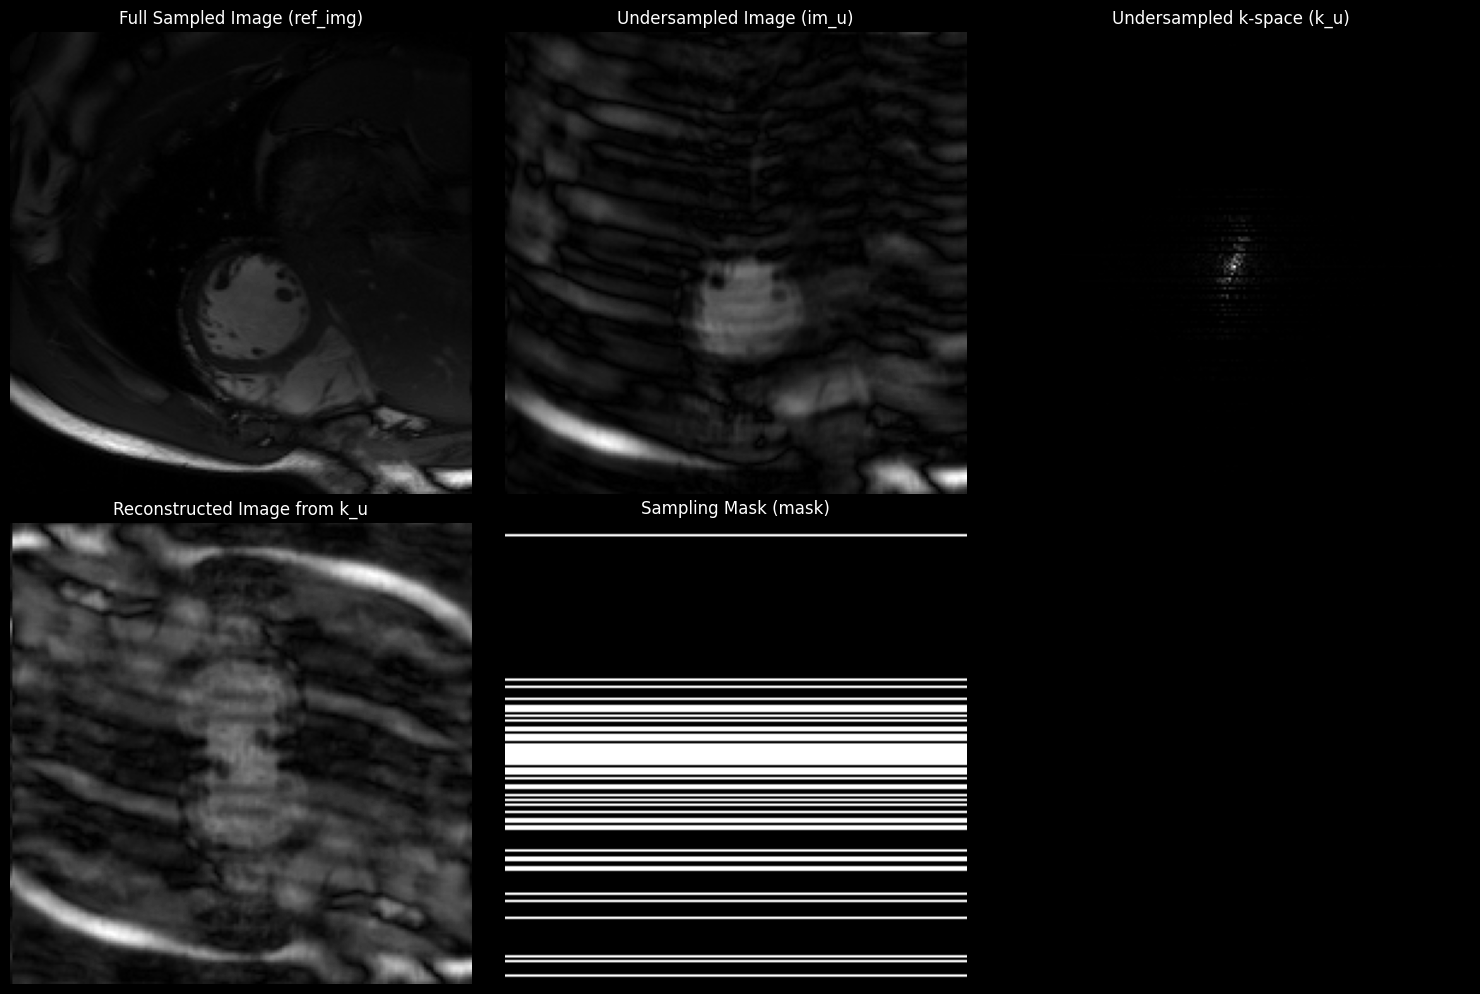

In [11]:
from utils.mri_related import fft2c,ifft2c ,MulticoilAdjointOp
# 测试欠采之后显示全采图、欠采图像、欠采kspace、欠采kspace转到图像域图像和mask

# 主逻辑代码来调用上述函数，实现加载模型、数据，并进行图片显示
# 模型文件路径，替换为你实际保存的模型文件路径
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn/model_101.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_241.pth'
# model_path = '/nfs/zzy/code/k_gin_base/models/dc_rnn_test/final_model.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_300.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test_3/model_281.pth'
# model_config  = get_config_model()
data_test_config = get_config_data_test()
data_config = data_test_config.get('data', {})  # 提取data部分配置信息，若不存在则返回空字典
print('data_config:',data_config)
# print('model_config:',model_config)
test_loader = load_test_data(data_config)
# model = load_model(model_path,model_config)

# test_loader = load_test_data(data_test_config)
# 将模型加载到相同设备
# model = model.to(device)

# kspace, orgk,coilmaps,sampling_mask orgk:欠采kspace
for i, (kspace, coilmaps, sampling_mask) in enumerate(test_loader):
# for i, (kspace, orgk,coilmaps,sampling_mask) in enumerate(test_loader):
    # test_loader-orgk-shape torch.Size([2, 20, 18, 192, 192])
    # test_loader-coilmaps-shape torch.Size([2, 20, 18, 192, 192])
    # test_loader-sampling_mask-shape torch.Size([2, 18, 20, 192, 192])
    # print('test_loader-orgk-shape',orgk.shape)
    # print('test_loader-coilmaps-shape',coilmaps.shape)
    # print('test_loader-sampling_mask-shape',sampling_mask.shape)
    if i >= 3:  # 只显示前5个示例图片，可根据需要调整数量
        break
    ref_kspace, ref_img = multicoil2single(kspace, coilmaps)
    ref_img = ref_img.squeeze()  # 去除批次维度
    print('ref_kspace-shape:',ref_kspace.shape)
    print('ref_img-shape:',ref_img.shape)
    
    
    # under_kspace, under_img = multicoil2single(orgk, coilmaps)
    # 得到欠采样图像
    # under_img = ifft2c(orgk)
    # under_img = under_img.squeeze()  # 去除批次维度
    # under_kspace-shape: torch.Size([2, 18, 192, 192])
    # under_img-shape: torch.Size([2, 18, 192, 192])
    # print('under_kspace-shape:',under_kspace.shape)
    # under_img-shape: torch.Size([2, 20, 18, 192, 192])
    # print('under_img-shape:',under_img.shape)
    # display_images_full(ref_img, under_img, ref_kspace, orgk, sampling_mask)
    # display_images_undersample(ref_img, under_img, under_kspace, sampling_mask)
    # break

    # 假设这里的处理逻辑和训练时的prep_input函数等保持一致，进行必要的数据预处理
    # 欠采样方法用的DCRNN的
    im_und, k_und, mask, im_gnd = prep_input(ref_img, acc=4.0,centred = True)  # acc参数需根据实际训练情况传入正确值
    # im_u = torch.from_numpy(to_tensor_format(im_und)).unsqueeze(0).type(torch.FloatTensor)  # 添加批次维度
    # k_u = torch.from_numpy(to_tensor_format(k_und)).unsqueeze(0).type(torch.FloatTensor)
    # mask = torch.from_numpy(to_tensor_format(mask)).unsqueeze(0).type(torch.FloatTensor)
    # 数据也需要移到相同设备
    im_u = Variable(im_und.type(Tensor)).to(device)
    k_u = Variable(k_und.type(Tensor)).to(device)
    mask = Variable(mask.type(Tensor)).to(device)
    gnd = Variable(im_gnd.type(Tensor)).to(device)
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    # im_u-shape: torch.Size([2, 2, 192, 192, 18])
    # k_u-shape: torch.Size([2, 2, 192, 192, 18])
    # mask-shape: torch.Size([2, 2, 192, 192, 18])
    print('ref_img-shape:',ref_img.shape)
    print('im_u-shape:',im_u.shape)
    print('k_u-shape:',k_u.shape)
    print('mask-shape:',mask.shape)
    
    display_images_undersample(ref_img, im_u, k_und, mask)
    break

    with torch.no_grad():
        reconstructed_image = model(im_u, k_u, mask, test=True)
    # reconstructed_image-shape: torch.Size([2, 2, 192, 192, 18])
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    print('reconstructed_image-shape-1:',reconstructed_image.shape)
    print('ref_img-shape:',ref_img.shape)
    # 对 reconstructed_image 取模值，合并通道
    reconstructed_image = torch.sqrt(reconstructed_image[:, 0, ...] ** 2 + reconstructed_image[:, 1, ...] ** 2)  # [2, 192, 192, 18]

    # 转置 reconstructed_image 的维度，匹配 ref_img 的形状
    reconstructed_image = reconstructed_image.permute(0, 3, 1, 2)  # [2, 18, 192, 192]
    print('reconstructed_image-shape-2:',reconstructed_image.shape)
    display_images(ref_img, reconstructed_image.squeeze())

In [4]:
import numpy as np
def cal_psnr(ref_img,under_img):
    # 假设 ref_img 和 under_img 是 NumPy 数组，且它们的尺寸相同
    # MAX_PIXEL_VALUE 通常为 255 对于8位图像
    MAX_PIXEL_VALUE = 255

    # 计算 MSE
    mse = np.mean((ref_img - under_img) ** 2)

    # 计算 PSNR
    if mse == 0:
        psnr = float('inf')  # 如果 MSE 为 0，则 PSNR 是无限大
    else:
        psnr = 20 * np.log10(MAX_PIXEL_VALUE / np.sqrt(mse))

    print(f"PSNR: {psnr}")


In [ ]:
# 主逻辑代码来调用上述函数，实现加载模型、数据，并进行图片显示
# 模型文件路径，替换为你实际保存的模型文件路径
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn/model_101.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_241.pth'
# model_path = '/nfs/zzy/code/k_gin_base/models/dc_rnn_test/final_model.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_300.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test_3/model_281.pth'
# model_config  = get_config_model()
data_test_config = get_config_data_test()
data_config = data_test_config.get('data', {})  # 提取data部分配置信息，若不存在则返回空字典
print('data_config:',data_config)
# print('model_config:',model_config)
test_loader = load_test_data(data_config)
# model = load_model(model_path,model_config)

# test_loader = load_test_data(data_test_config)
# 将模型加载到相同设备
# model = model.to(device)

# kspace, orgk,coilmaps,sampling_mask orgk:欠采kspace
# for i, (kspace, coilmaps, sampling_mask) in enumerate(test_loader):
for i, (kspace,coilmaps,sampling_mask) in enumerate(test_loader):
    # print('test_loader-orgk-shape',orgk.shape)
    # print('test_loader-coilmaps-shape',orgk.shape)
    if i >= 3:  # 只显示前5个示例图片，可根据需要调整数量
        break
    ref_kspace, ref_img = multicoil2single(kspace, coilmaps)
    ref_img = ref_img.squeeze()  # 去除批次维度
    # print('')
    
    # under_kspace, under_img = multicoil2single(orgk, coilmaps)
    # under_img = under_img.squeeze()  # 去除批次维度
    # print('',)
    # cal_psnr(ref_img,under_img)
    
    # display_images_undersample(ref_img, under_img, under_kspace, sampling_mask)
    break

    # 假设这里的处理逻辑和训练时的prep_input函数等保持一致，进行必要的数据预处理
    # 欠采样方法用的DCRNN的
    im_und, k_und, mask, im_gnd = prep_input(ref_img, acc=4.0)  # acc参数需根据实际训练情况传入正确值
    # im_u = torch.from_numpy(to_tensor_format(im_und)).unsqueeze(0).type(torch.FloatTensor)  # 添加批次维度
    # k_u = torch.from_numpy(to_tensor_format(k_und)).unsqueeze(0).type(torch.FloatTensor)
    # mask = torch.from_numpy(to_tensor_format(mask)).unsqueeze(0).type(torch.FloatTensor)
    # 数据也需要移到相同设备
    im_u = Variable(im_und.type(Tensor)).to(device)
    k_u = Variable(k_und.type(Tensor)).to(device)
    mask = Variable(mask.type(Tensor)).to(device)
    gnd = Variable(im_gnd.type(Tensor)).to(device)
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    # im_u-shape: torch.Size([2, 2, 192, 192, 18])
    # k_u-shape: torch.Size([2, 2, 192, 192, 18])
    # mask-shape: torch.Size([2, 2, 192, 192, 18])
    print('ref_img-shape:',ref_img.shape)
    print('im_u-shape:',im_u.shape)
    print('k_u-shape:',k_u.shape)
    print('mask-shape:',mask.shape)
    
    # display_images_undersample(ref_img, im_u, k_und, mask)
    # break

    with torch.no_grad():
        reconstructed_image = model(im_u, k_u, mask, test=True)
    # reconstructed_image-shape: torch.Size([2, 2, 192, 192, 18])
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    print('reconstructed_image-shape-1:',reconstructed_image.shape)
    print('ref_img-shape:',ref_img.shape)
    # 对 reconstructed_image 取模值，合并通道
    reconstructed_image = torch.sqrt(reconstructed_image[:, 0, ...] ** 2 + reconstructed_image[:, 1, ...] ** 2)  # [2, 192, 192, 18]

    # 转置 reconstructed_image 的维度，匹配 ref_img 的形状
    reconstructed_image = reconstructed_image.permute(0, 3, 1, 2)  # [2, 18, 192, 192]
    print('reconstructed_image-shape-2:',reconstructed_image.shape)
    display_images(ref_img, reconstructed_image.squeeze())

data_config: {'train_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy', 'train_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_training.npy', 'val_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy', 'val_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy', 'mask_root': 'masks/VISTA/e_192x18_acs4_R4.mat', 'data_root': '/data0/chentao/data/LplusSNet/data/20coil', 'mask_pattern': 'VISTA', 'acc_rate': [4], 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}


ValueError: not enough values to unpack (expected 4, got 3)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def display_images_full(ref_img, under_img, ref_kspace, orgk, sampling_mask):
    """
    显示全采图像、欠采图像、全采 k-space、欠采 k-space 和掩码。

    参数:
    ref_img: 全采图像，形状为 [2, 18, 192, 192]。
    under_img: 欠采图像，形状为 [2, 18, 192, 192]。
    ref_kspace: 全采 k-space，形状为 [2, 18, 192, 192]。
    orgk: 欠采 k-space，形状为 [2, 20, 18, 192, 192]。
    sampling_mask: 掩码，形状为 [2, 18, 20, 192, 192]。
    """
    # 确保输入数据为 NumPy 格式
    ref_img = ref_img.cpu().numpy()
    under_img = under_img.cpu().numpy()
    ref_kspace = ref_kspace.cpu().numpy()
    orgk = orgk.cpu().numpy()
    sampling_mask = sampling_mask.cpu().numpy()

    # 提取第一个 batch 的第一个时间帧
    ref_img_display = np.abs(ref_img[0, 0])  # [192, 192]
    under_img_display = np.abs(under_img[0, 0,0])  # [192, 192]
    ref_kspace_display = np.abs(ref_kspace[0, 0])  # [192, 192]
    orgk_display = np.abs(orgk[0, 0, 0])  # [192, 192]
    mask_display = sampling_mask[0, 0, 0]  # [192, 192]

    # 归一化并增强亮度
    ref_img_norm = ref_img_display / np.max(ref_img_display)
    under_img_norm = under_img_display / np.max(under_img_display)
    ref_kspace_norm = ref_kspace_display / np.max(ref_kspace_display)
    orgk_norm = orgk_display / np.max(orgk_display)

    # 创建子图
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 显示全采图像
    axes[0, 0].imshow(ref_img_norm, cmap='gray')
    axes[0, 0].set_title('Full Sampled Image (ref_img)')
    axes[0, 0].axis('off')

    # 显示欠采图像
    axes[0, 1].imshow(under_img_norm, cmap='gray')
    axes[0, 1].set_title('Undersampled Image (under_img)')
    axes[0, 1].axis('off')

    # 显示全采 k-space
    axes[0, 2].imshow(ref_kspace_norm, cmap='gray')
    axes[0, 2].set_title('Full Sampled k-space (ref_kspace)')
    axes[0, 2].axis('off')

    # 显示欠采 k-space
    axes[1, 0].imshow(orgk_norm, cmap='gray')
    axes[1, 0].set_title('Undersampled k-space (orgk)')
    axes[1, 0].axis('off')

    # 显示掩码
    axes[1, 1].imshow(mask_display, cmap='gray')
    axes[1, 1].set_title('Sampling Mask (mask)')
    axes[1, 1].axis('off')

    # 隐藏多余的子图
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

data_config: {'train_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy', 'train_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_training.npy', 'val_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy', 'val_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy', 'mask_root': 'masks/VISTA/e_192x18_acs4_R4.mat', 'data_root': '/data0/chentao/data/LplusSNet/data/20coil', 'mask_pattern': 'VISTA', 'acc_rate': [4], 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}
ref_kspace-shape: torch.Size([2, 18, 192, 192])
ref_img-shape: torch.Size([2, 18, 192, 192])
under_img-shape: torch.Size([2, 20, 18, 192, 192])


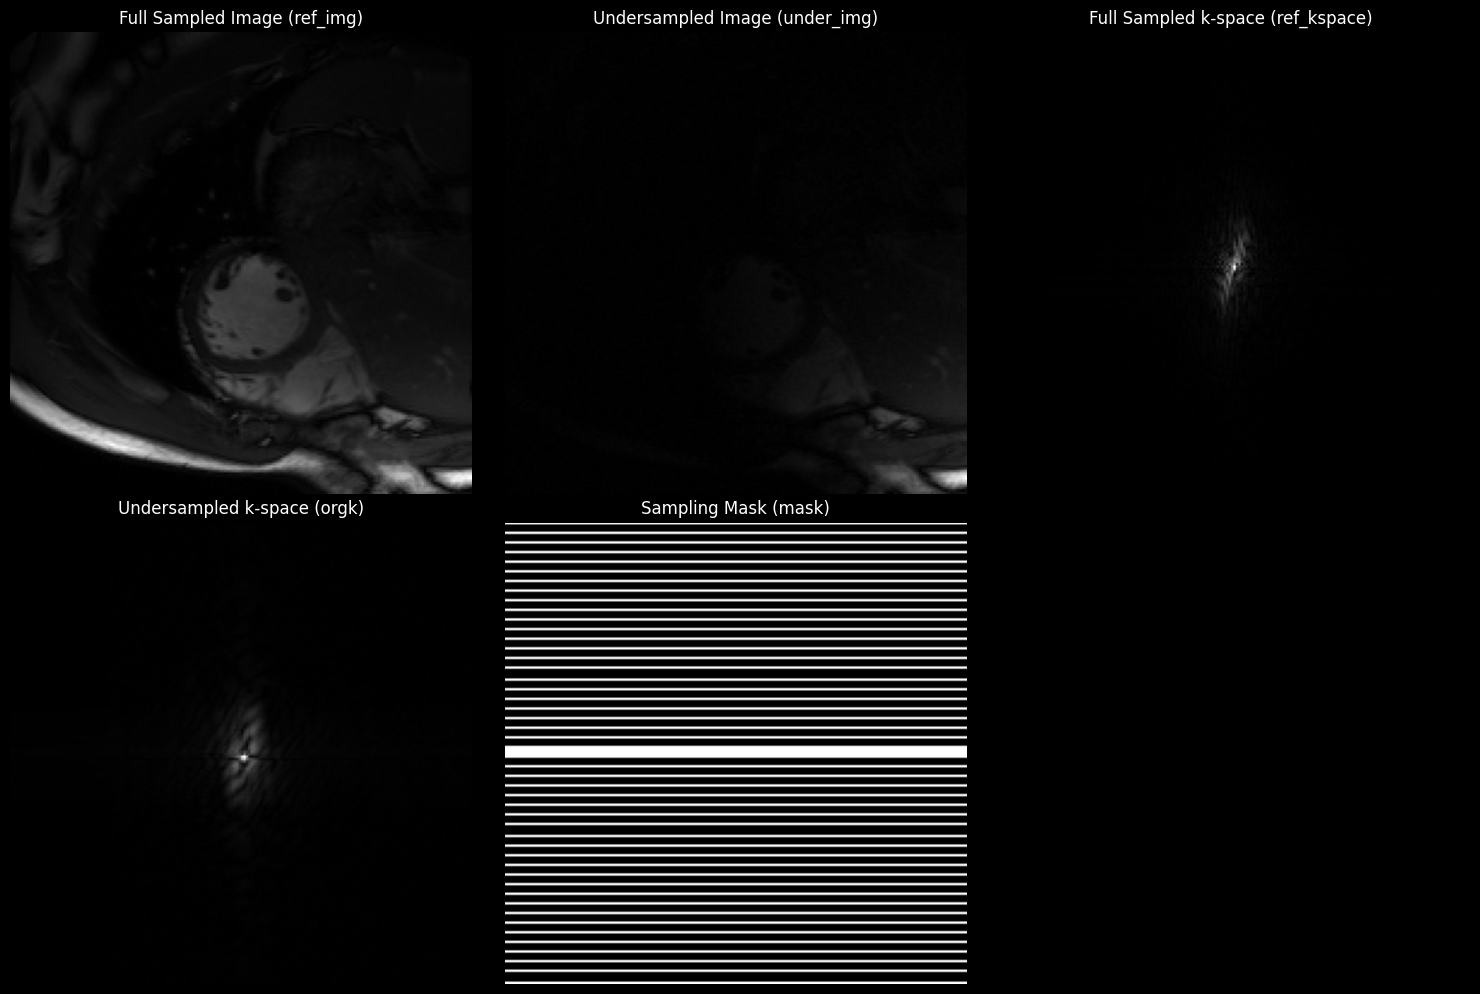

In [ ]:
from utils.mri_related import fft2c,ifft2c ,MulticoilAdjointOp

# 主逻辑代码来调用上述函数，实现加载模型、数据，并进行图片显示
# 模型文件路径，替换为你实际保存的模型文件路径
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn/model_101.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_241.pth'
# model_path = '/nfs/zzy/code/k_gin_base/models/dc_rnn_test/final_model.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_300.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test_3/model_281.pth'
# model_config  = get_config_model()
data_test_config = get_config_data_test()
data_config = data_test_config.get('data', {})  # 提取data部分配置信息，若不存在则返回空字典
print('data_config:',data_config)
# print('model_config:',model_config)
test_loader = load_test_data(data_config)
# model = load_model(model_path,model_config)

# test_loader = load_test_data(data_test_config)
# 将模型加载到相同设备
# model = model.to(device)

# kspace, orgk,coilmaps,sampling_mask orgk:欠采kspace
# for i, (kspace, coilmaps, sampling_mask) in enumerate(test_loader):
for i, (kspace, orgk,coilmaps,sampling_mask) in enumerate(test_loader):
    # test_loader-orgk-shape torch.Size([2, 20, 18, 192, 192])
    # test_loader-coilmaps-shape torch.Size([2, 20, 18, 192, 192])
    # test_loader-sampling_mask-shape torch.Size([2, 18, 20, 192, 192])
    # print('test_loader-orgk-shape',orgk.shape)
    # print('test_loader-coilmaps-shape',coilmaps.shape)
    # print('test_loader-sampling_mask-shape',sampling_mask.shape)
    if i >= 3:  # 只显示前5个示例图片，可根据需要调整数量
        break
    ref_kspace, ref_img = multicoil2single(kspace, coilmaps)
    ref_img = ref_img.squeeze()  # 去除批次维度
    print('ref_kspace-shape:',ref_kspace.shape)
    print('ref_img-shape:',ref_img.shape)
    
    
    # under_kspace, under_img = multicoil2single(orgk, coilmaps)
    # 得到欠采样图像
    under_img = ifft2c(orgk)
    under_img = under_img.squeeze()  # 去除批次维度
    # under_kspace-shape: torch.Size([2, 18, 192, 192])
    # under_img-shape: torch.Size([2, 18, 192, 192])
    # print('under_kspace-shape:',under_kspace.shape)
    # under_img-shape: torch.Size([2, 20, 18, 192, 192])
    print('under_img-shape:',under_img.shape)
    display_images_full(ref_img, under_img, ref_kspace, orgk, sampling_mask)
    # display_images_undersample(ref_img, under_img, under_kspace, sampling_mask)
    break

    # 假设这里的处理逻辑和训练时的prep_input函数等保持一致，进行必要的数据预处理
    # 欠采样方法用的DCRNN的
    im_und, k_und, mask, im_gnd = prep_input(ref_img, acc=4.0)  # acc参数需根据实际训练情况传入正确值
    # im_u = torch.from_numpy(to_tensor_format(im_und)).unsqueeze(0).type(torch.FloatTensor)  # 添加批次维度
    # k_u = torch.from_numpy(to_tensor_format(k_und)).unsqueeze(0).type(torch.FloatTensor)
    # mask = torch.from_numpy(to_tensor_format(mask)).unsqueeze(0).type(torch.FloatTensor)
    # 数据也需要移到相同设备
    im_u = Variable(im_und.type(Tensor)).to(device)
    k_u = Variable(k_und.type(Tensor)).to(device)
    mask = Variable(mask.type(Tensor)).to(device)
    gnd = Variable(im_gnd.type(Tensor)).to(device)
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    # im_u-shape: torch.Size([2, 2, 192, 192, 18])
    # k_u-shape: torch.Size([2, 2, 192, 192, 18])
    # mask-shape: torch.Size([2, 2, 192, 192, 18])
    print('ref_img-shape:',ref_img.shape)
    print('im_u-shape:',im_u.shape)
    print('k_u-shape:',k_u.shape)
    print('mask-shape:',mask.shape)
    
    # display_images_undersample(ref_img, im_u, k_und, mask)
    # break

    with torch.no_grad():
        reconstructed_image = model(im_u, k_u, mask, test=True)
    # reconstructed_image-shape: torch.Size([2, 2, 192, 192, 18])
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    print('reconstructed_image-shape-1:',reconstructed_image.shape)
    print('ref_img-shape:',ref_img.shape)
    # 对 reconstructed_image 取模值，合并通道
    reconstructed_image = torch.sqrt(reconstructed_image[:, 0, ...] ** 2 + reconstructed_image[:, 1, ...] ** 2)  # [2, 192, 192, 18]

    # 转置 reconstructed_image 的维度，匹配 ref_img 的形状
    reconstructed_image = reconstructed_image.permute(0, 3, 1, 2)  # [2, 18, 192, 192]
    print('reconstructed_image-shape-2:',reconstructed_image.shape)
    display_images(ref_img, reconstructed_image.squeeze())

### 测试欠采之后显示全采图、欠采图像、欠采kspace、欠采kspace转到图像域图像和mask

data_config: {'train_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy', 'train_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_training.npy', 'val_subjs': '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy', 'val_maps': '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy', 'mask_root': 'masks/VISTA/e_192x18_acs4_R4.mat', 'data_root': '/data0/chentao/data/LplusSNet/data/20coil', 'mask_pattern': 'VISTA', 'acc_rate': [4], 'dtype': 'complex128', 'training_patch_time': 16, 'only_infer': False}
ref_kspace-shape: torch.Size([2, 18, 192, 192])
ref_img-shape: torch.Size([2, 18, 192, 192])
prep_input-mask_permuted-shape: torch.Size([2, 18, 192, 192])
prep_input-mask_l-shape-1: torch.Size([2, 2, 192, 192, 18])
prep_input-mask_l-shape-2: torch.Size([2, 2, 192, 192, 18])
ref_img-shape: torch.Size([2, 18, 192, 192])
im_u-shape: torch.Size([2, 2, 192, 192, 18])
k_u-shape: torch.Size([2, 2, 192, 192, 18])
mask-sh

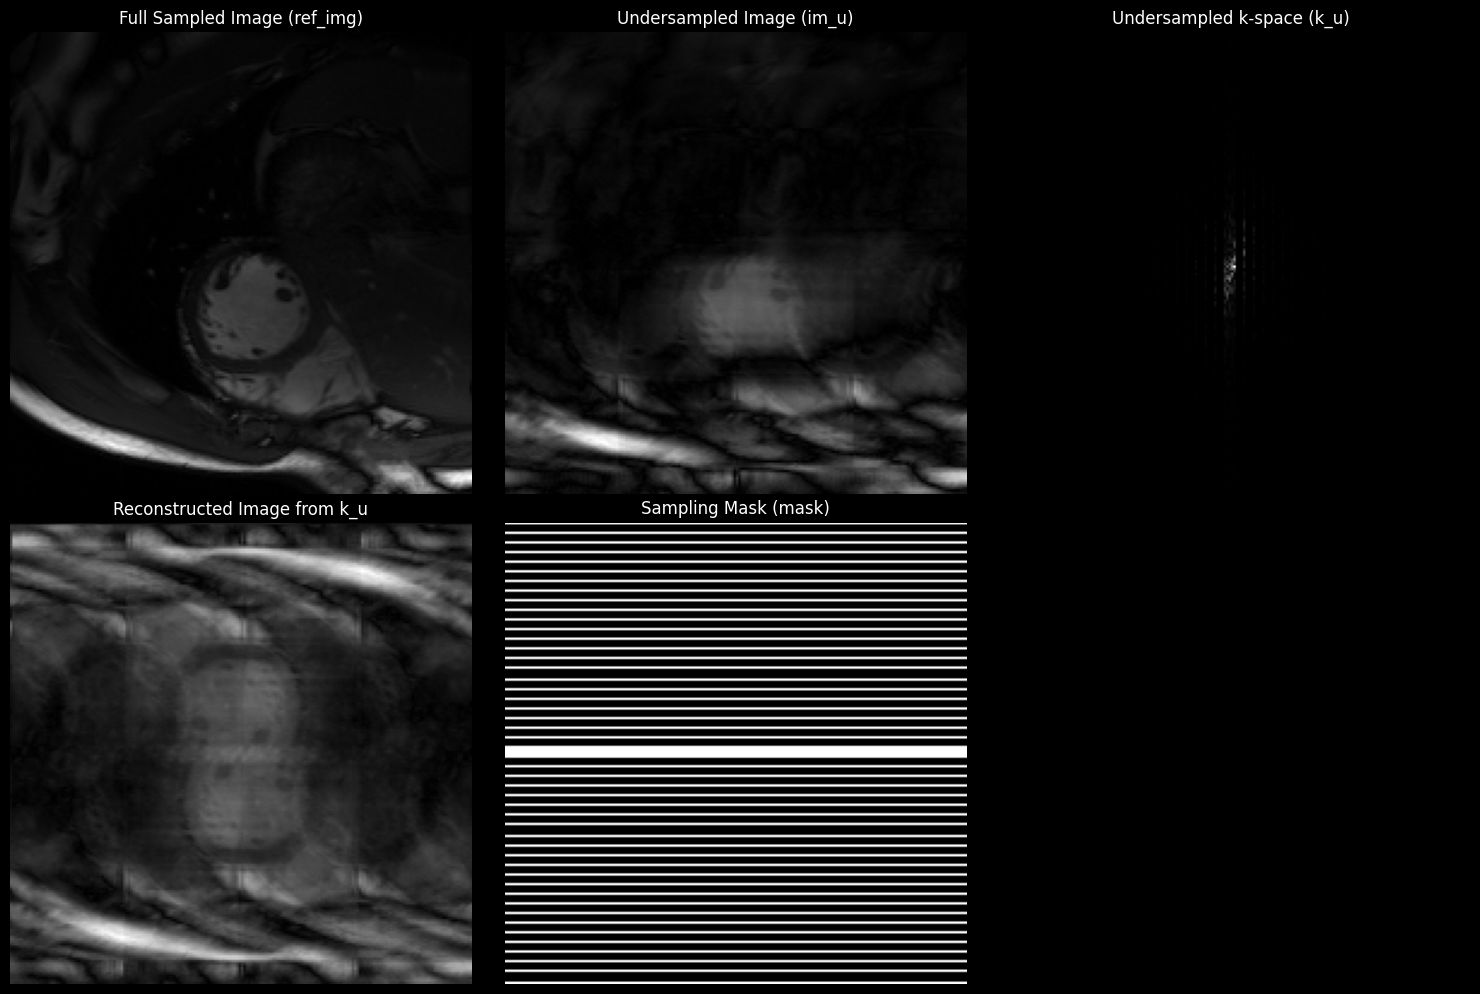

In [4]:
from utils.mri_related import fft2c,ifft2c ,MulticoilAdjointOp
# 测试欠采之后显示全采图、欠采图像、欠采kspace、欠采kspace转到图像域图像和mask

# 主逻辑代码来调用上述函数，实现加载模型、数据，并进行图片显示
# 模型文件路径，替换为你实际保存的模型文件路径
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn/model_101.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_241.pth'
# model_path = '/nfs/zzy/code/k_gin_base/models/dc_rnn_test/final_model.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test/model_300.pth'
# model_path = '/nfs/zzy/code/k_gin_base/experiments/test_dcrnn_test_3/model_281.pth'
# model_config  = get_config_model()
data_test_config = get_config_data_test()
data_config = data_test_config.get('data', {})  # 提取data部分配置信息，若不存在则返回空字典
print('data_config:',data_config)
# print('model_config:',model_config)
test_loader = load_test_data(data_config)
# model = load_model(model_path,model_config)

# test_loader = load_test_data(data_test_config)
# 将模型加载到相同设备
# model = model.to(device)

# kspace, orgk,coilmaps,sampling_mask orgk:欠采kspace
for i, (kspace, coilmaps, sampling_mask) in enumerate(test_loader):
# for i, (kspace, orgk,coilmaps,sampling_mask) in enumerate(test_loader):
    # test_loader-orgk-shape torch.Size([2, 20, 18, 192, 192])
    # test_loader-coilmaps-shape torch.Size([2, 20, 18, 192, 192])
    # test_loader-sampling_mask-shape torch.Size([2, 18, 20, 192, 192])
    # print('test_loader-orgk-shape',orgk.shape)
    # print('test_loader-coilmaps-shape',coilmaps.shape)
    # print('test_loader-sampling_mask-shape',sampling_mask.shape)
    if i >= 3:  # 只显示前5个示例图片，可根据需要调整数量
        break
    ref_kspace, ref_img = multicoil2single(kspace, coilmaps)
    ref_img = ref_img.squeeze()  # 去除批次维度
    print('ref_kspace-shape:',ref_kspace.shape)
    print('ref_img-shape:',ref_img.shape)
    
    
    # under_kspace, under_img = multicoil2single(orgk, coilmaps)
    # 得到欠采样图像
    # under_img = ifft2c(orgk)
    # under_img = under_img.squeeze()  # 去除批次维度
    # under_kspace-shape: torch.Size([2, 18, 192, 192])
    # under_img-shape: torch.Size([2, 18, 192, 192])
    # print('under_kspace-shape:',under_kspace.shape)
    # under_img-shape: torch.Size([2, 20, 18, 192, 192])
    # print('under_img-shape:',under_img.shape)
    # display_images_full(ref_img, under_img, ref_kspace, orgk, sampling_mask)
    # display_images_undersample(ref_img, under_img, under_kspace, sampling_mask)
    # break

    # 假设这里的处理逻辑和训练时的prep_input函数等保持一致，进行必要的数据预处理
    # 欠采样方法用的DCRNN的
    im_und, k_und, mask, im_gnd = prep_input(ref_img, acc=4.0)  # acc参数需根据实际训练情况传入正确值
    # im_u = torch.from_numpy(to_tensor_format(im_und)).unsqueeze(0).type(torch.FloatTensor)  # 添加批次维度
    # k_u = torch.from_numpy(to_tensor_format(k_und)).unsqueeze(0).type(torch.FloatTensor)
    # mask = torch.from_numpy(to_tensor_format(mask)).unsqueeze(0).type(torch.FloatTensor)
    # 数据也需要移到相同设备
    im_u = Variable(im_und.type(Tensor)).to(device)
    k_u = Variable(k_und.type(Tensor)).to(device)
    mask = Variable(mask.type(Tensor)).to(device)
    gnd = Variable(im_gnd.type(Tensor)).to(device)
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    # im_u-shape: torch.Size([2, 2, 192, 192, 18])
    # k_u-shape: torch.Size([2, 2, 192, 192, 18])
    # mask-shape: torch.Size([2, 2, 192, 192, 18])
    print('ref_img-shape:',ref_img.shape)
    print('im_u-shape:',im_u.shape)
    print('k_u-shape:',k_u.shape)
    print('mask-shape:',mask.shape)
    
    display_images_undersample(ref_img, im_u, k_und, mask)
    break

    with torch.no_grad():
        reconstructed_image = model(im_u, k_u, mask, test=True)
    # reconstructed_image-shape: torch.Size([2, 2, 192, 192, 18])
    # ref_img-shape: torch.Size([2, 18, 192, 192])
    print('reconstructed_image-shape-1:',reconstructed_image.shape)
    print('ref_img-shape:',ref_img.shape)
    # 对 reconstructed_image 取模值，合并通道
    reconstructed_image = torch.sqrt(reconstructed_image[:, 0, ...] ** 2 + reconstructed_image[:, 1, ...] ** 2)  # [2, 192, 192, 18]

    # 转置 reconstructed_image 的维度，匹配 ref_img 的形状
    reconstructed_image = reconstructed_image.permute(0, 3, 1, 2)  # [2, 18, 192, 192]
    print('reconstructed_image-shape-2:',reconstructed_image.shape)
    display_images(ref_img, reconstructed_image.squeeze())